# Warehouse Optimization - 9×9, Zipf 0.9, 4 agenti, A* planner

**Parametry:**
- Mapa: **9×9**
- Agenti: **4**
- Planner: **A*** (space-time)
- Distribuce: **Zipf 0.9**
- Populace: 5
- Generace: 100

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import time

from warehouse import Warehouse, OrderGenerator
from mapd_solver import MAPDSimulator
from surrogate import SurrogateModel, extract_features, compare_models
from evolution import run_evolution, collect_initial_data
from baselines import run_all_baselines

%matplotlib inline

In [ ]:
# Parametry experimentu
GRID_SIZE = 9
N_AGENTS = 4  # Zvýšeno z 2 na 4 - více agentů = layout má větší vliv
SIM_STEPS = 300
ORDER_LAMBDA = 0.5  # Zvýšeno pro více objednávek
SEED = 42

# Planner
PLANNER_TYPE = "astar"

# Distribuce - Zipf 0.9
DISTRIBUTION = "zipf"
ZIPF_PARAM = 0.9

# EA parametry
POP_SIZE = 5
N_GENERATIONS = 100
REAL_EVAL_INTERVAL = 10

# Surrogate parametry
INIT_SAMPLES = 500

## 1. Distribuce objednávek

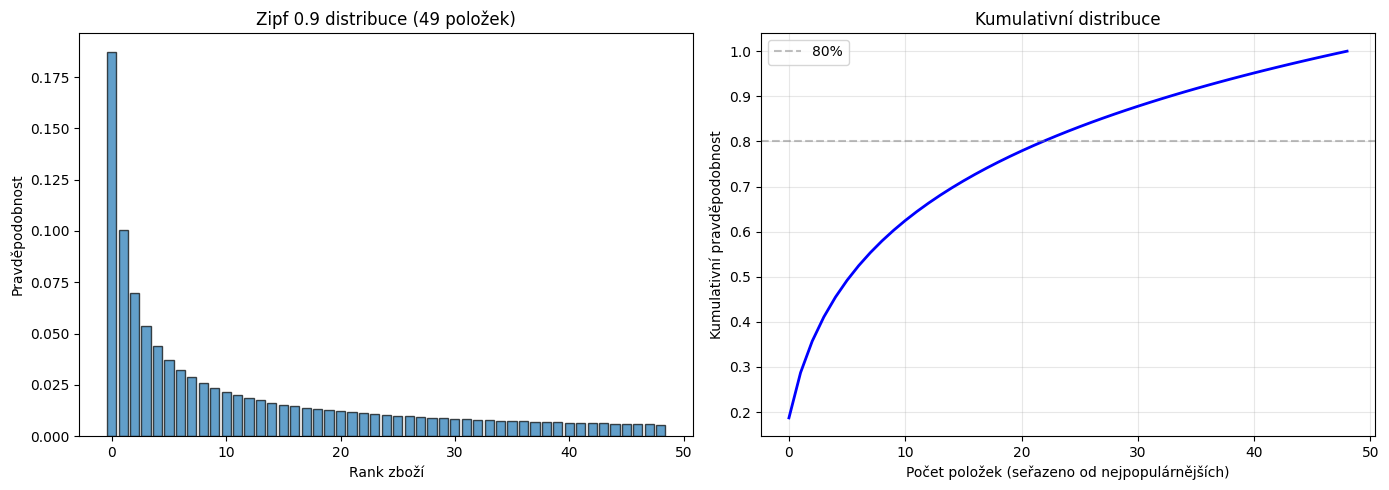

Statistiky Zipf 0.9:
  Počet položek: 49
  Max prob: 0.1872
  Min prob: 0.0056
  Ratio max/min: 33.2x
  Top 5 tvoří 45.5% objednávek


In [88]:
n_goods = (GRID_SIZE - 2) ** 2

og_test = OrderGenerator(n_goods, distribution="zipf", zipf_param=ZIPF_PARAM, seed=SEED)
probs = og_test.get_probabilities()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
ax1.bar(range(n_goods), np.sort(probs)[::-1], alpha=0.7, edgecolor='black')
ax1.set_xlabel('Rank zboží')
ax1.set_ylabel('Pravděpodobnost')
ax1.set_title(f'Zipf {ZIPF_PARAM} distribuce ({n_goods} položek)')

# Kumulativní distribuce
ax2 = axes[1]
ax2.plot(np.cumsum(np.sort(probs)[::-1]), 'b-', linewidth=2)
ax2.axhline(0.8, color='gray', linestyle='--', alpha=0.5, label='80%')
ax2.set_xlabel('Počet položek (seřazeno od nejpopulárnějších)')
ax2.set_ylabel('Kumulativní pravděpodobnost')
ax2.set_title('Kumulativní distribuce')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Statistiky Zipf {ZIPF_PARAM}:")
print(f"  Počet položek: {n_goods}")
print(f"  Max prob: {probs.max():.4f}")
print(f"  Min prob: {probs.min():.4f}")
print(f"  Ratio max/min: {probs.max()/probs.min():.1f}x")
print(f"  Top 5 tvoří {np.sort(probs)[-5:].sum()*100:.1f}% objednávek")

## 2. Vytvoření skladu

In [89]:
wh = Warehouse(GRID_SIZE, GRID_SIZE)
og = OrderGenerator(wh.n_inner, distribution=DISTRIBUTION, zipf_param=ZIPF_PARAM, seed=SEED)

print(f"Velikost: {GRID_SIZE}x{GRID_SIZE}")
print(f"Počet vnitřních pozic (zboží): {wh.n_inner}")
print(f"Počet delivery points: {len(wh.get_delivery_points())}")
print(f"Distribuce: {DISTRIBUTION} s parametrem {ZIPF_PARAM}")
print(f"Počet agentů: {N_AGENTS}")
print(f"Planner: {PLANNER_TYPE.upper()}")

Velikost: 9x9
Počet vnitřních pozic (zboží): 49
Počet delivery points: 32
Distribuce: zipf s parametrem 0.9
Počet agentů: 4
Planner: ASTAR


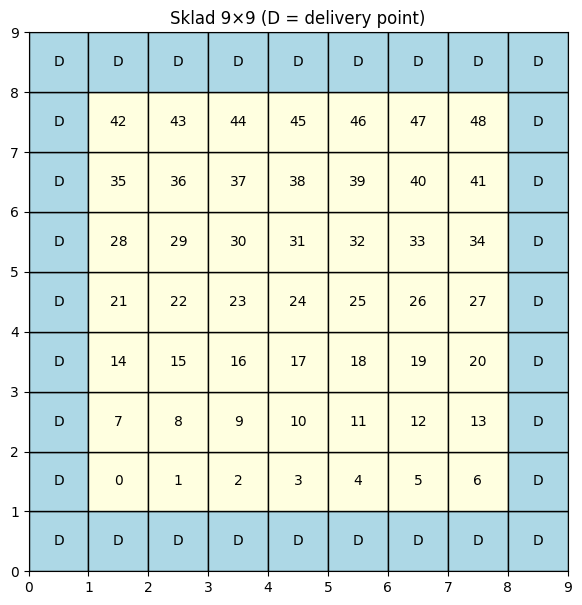

In [90]:
# Vizualizace prázdného skladu
fig, ax = plt.subplots(figsize=(7, 7))

for y in range(GRID_SIZE):
    for x in range(GRID_SIZE):
        if x == 0 or x == GRID_SIZE-1 or y == 0 or y == GRID_SIZE-1:
            color = 'lightblue'
            label = 'D'
        else:
            color = 'lightyellow'
            inner_idx = (y - 1) * (GRID_SIZE - 2) + (x - 1)
            label = str(inner_idx)
        
        ax.add_patch(plt.Rectangle((x, y), 1, 1, facecolor=color, edgecolor='black'))
        ax.text(x + 0.5, y + 0.5, label, ha='center', va='center', fontsize=10)

ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(0, GRID_SIZE)
ax.set_aspect('equal')
ax.set_title(f'Sklad {GRID_SIZE}×{GRID_SIZE} (D = delivery point)')
plt.show()

## 3. Baseline metody

In [91]:
print(f"Používám A* planner\n")

baseline_results = run_all_baselines(
    wh, og, n_agents=N_AGENTS,
    random_samples=50,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)

Používám A* planner

Running baselines (planner: astar)...

1. Random baseline:
  Random: 20/50 samples, best so far: 0.5067
  Random: 40/50 samples, best so far: 0.5067

2. Greedy baseline:
  Greedy fitness: 0.4633

3. Inverse greedy baseline:
  Inverse greedy fitness: 0.2767


In [92]:
print("Souhrn baseline:")
print(f"  Random:         best={baseline_results['random']['best_fitness']:.4f}, "
      f"mean={baseline_results['random']['mean_fitness']:.4f}")
print(f"  Greedy:         {baseline_results['greedy']['fitness']:.4f}")
print(f"  Inverse Greedy: {baseline_results['inverse_greedy']['fitness']:.4f}")

Souhrn baseline:
  Random:         best=0.5367, mean=0.3718
  Greedy:         0.4633
  Inverse Greedy: 0.2767


## 4. Sběr dat pro surrogate model

In [93]:
print(f"Sbírám {INIT_SAMPLES} vzorků s {N_AGENTS} agenty (A* planner)...\n")
start_time = time.time()

features_list, fitness_list, layouts_list = collect_initial_data(
    wh, og, n_agents=N_AGENTS,
    n_samples=INIT_SAMPLES,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)

collect_time = time.time() - start_time
print(f"\nČas sběru dat: {collect_time:.1f}s")

X_data = np.array(features_list)
y_data = np.array(fitness_list)

print(f"Features shape: {X_data.shape}")
print(f"Rozsah fitness: [{y_data.min():.4f}, {y_data.max():.4f}]")
print(f"Průměr fitness: {y_data.mean():.4f} ± {y_data.std():.4f}")

Sbírám 500 vzorků s 4 agenty (A* planner)...

  Collected 10/500 samples
  Collected 20/500 samples
  Collected 30/500 samples
  Collected 40/500 samples
  Collected 50/500 samples
  Collected 60/500 samples
  Collected 70/500 samples
  Collected 80/500 samples
  Collected 90/500 samples
  Collected 100/500 samples
  Collected 110/500 samples
  Collected 120/500 samples
  Collected 130/500 samples
  Collected 140/500 samples
  Collected 150/500 samples
  Collected 160/500 samples
  Collected 170/500 samples
  Collected 180/500 samples
  Collected 190/500 samples
  Collected 200/500 samples
  Collected 210/500 samples
  Collected 220/500 samples
  Collected 230/500 samples
  Collected 240/500 samples
  Collected 250/500 samples
  Collected 260/500 samples
  Collected 270/500 samples
  Collected 280/500 samples
  Collected 290/500 samples
  Collected 300/500 samples
  Collected 310/500 samples
  Collected 320/500 samples
  Collected 330/500 samples
  Collected 340/500 samples
  Collected

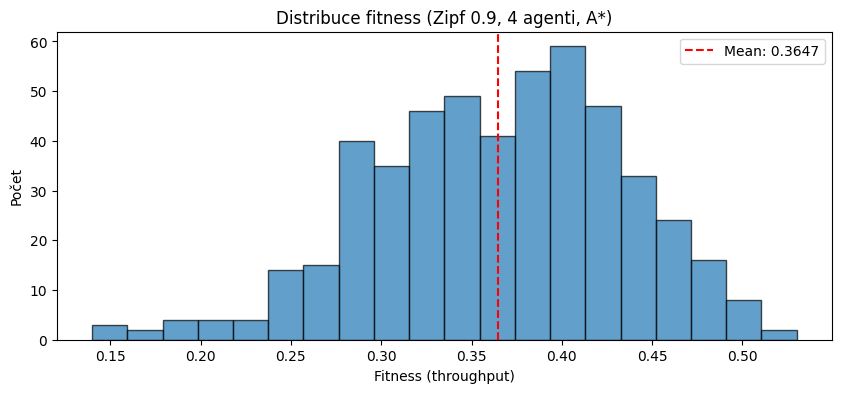

In [94]:
# Histogram fitness hodnot
plt.figure(figsize=(10, 4))
plt.hist(y_data, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(y_data.mean(), color='red', linestyle='--', label=f'Mean: {y_data.mean():.4f}')
plt.xlabel('Fitness (throughput)')
plt.ylabel('Počet')
plt.title(f'Distribuce fitness (Zipf {ZIPF_PARAM}, {N_AGENTS} agenti, A*)')
plt.legend()
plt.show()

## 5. Porovnání surrogate modelů

In [95]:
model_comparison = compare_models(X_data, y_data, cv=5)

print("Cross-validation R² skóre:")
for name, scores in model_comparison.items():
    print(f"  {name:10s}: {scores['r2_mean']:.3f} ± {scores['r2_std']:.3f}")

best_model_name = max(model_comparison.keys(),
                      key=lambda k: model_comparison[k]['r2_mean'])
print(f"\nNejlepší model: {best_model_name}")

Cross-validation R² skóre:
  linear    : -0.002 ± 0.093
  ridge     : 0.036 ± 0.063
  gp        : 0.065 ± 0.035
  rf        : -0.002 ± 0.105

Nejlepší model: gp


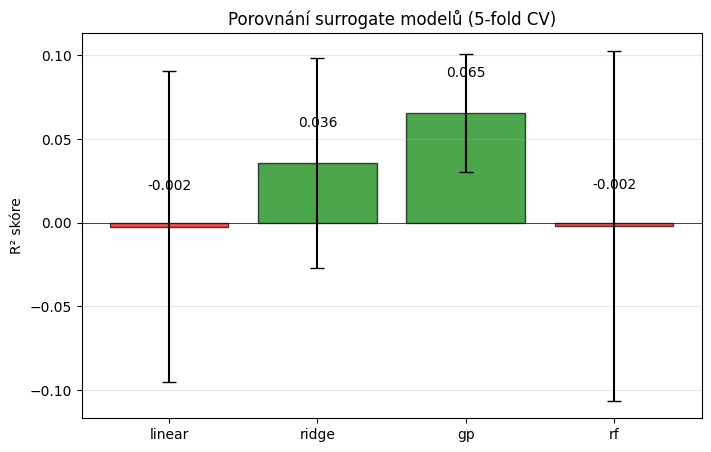

In [96]:
# Vizualizace R² skóre
fig, ax = plt.subplots(figsize=(8, 5))

names = list(model_comparison.keys())
means = [model_comparison[n]['r2_mean'] for n in names]
stds = [model_comparison[n]['r2_std'] for n in names]

colors = ['green' if m > 0 else 'red' for m in means]
bars = ax.bar(names, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black', color=colors)
ax.set_ylabel('R² skóre')
ax.set_title('Porovnání surrogate modelů (5-fold CV)')
ax.axhline(0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{mean:.3f}', ha='center', va='bottom')

plt.show()

## 6. Evoluce BEZ surrogate

In [97]:
print(f"Populace: {POP_SIZE}, Generace: {N_GENERATIONS}")
print(f"Agenti: {N_AGENTS}, Planner: {PLANNER_TYPE.upper()}\n")

ea_no_surrogate = run_evolution(
    wh, og, n_agents=N_AGENTS,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    use_surrogate=False,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)

print(f"\nVýsledky bez surrogate:")
print(f"  Nejlepší fitness: {ea_no_surrogate['best_fitness']:.4f}")
print(f"  Reálných evaluací: {ea_no_surrogate['real_evals']}")
print(f"  Čas: {ea_no_surrogate['wall_time']:.1f}s")

Populace: 5, Generace: 100
Agenti: 4, Planner: ASTAR

Gen 0: best=0.4200, avg=0.3800, std=0.0290
Gen 10: best=0.4433, avg=0.3380
Gen 20: best=0.4367, avg=0.3687
Gen 30: best=0.4500, avg=0.3673
Gen 40: best=0.4400, avg=0.3647
Gen 50: best=0.5100, avg=0.4733
Gen 60: best=0.4400, avg=0.3533
Gen 70: best=0.4867, avg=0.3847
Gen 80: best=0.4867, avg=0.3753
Gen 90: best=0.4467, avg=0.3693
Gen 100: best=0.4300, avg=0.3393

Výsledky bez surrogate:
  Nejlepší fitness: 0.5567
  Reálných evaluací: 505
  Čas: 345.9s


## 7. Evoluce SE surrogate

In [98]:
print(f"Populace: {POP_SIZE}, Generace: {N_GENERATIONS}")
print(f"Surrogate model: {best_model_name}")
print(f"Reálná evaluace každých {REAL_EVAL_INTERVAL} generací\n")

ea_with_surrogate = run_evolution(
    wh, og, n_agents=N_AGENTS,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    use_surrogate=True,
    surrogate_type=best_model_name,
    real_eval_interval=REAL_EVAL_INTERVAL,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)

print(f"\nVýsledky se surrogate:")
print(f"  Nejlepší fitness: {ea_with_surrogate['best_fitness']:.4f}")
print(f"  Reálných evaluací: {ea_with_surrogate['real_evals']}")
print(f"  Surrogate evaluací: {ea_with_surrogate['surrogate_evals']}")
print(f"  Čas: {ea_with_surrogate['wall_time']:.1f}s")

Populace: 5, Generace: 100
Surrogate model: gp
Reálná evaluace každých 10 generací



/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

Gen 0: best=0.4333, avg=0.3907, std=0.0288


/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Gen 10: best=0.3901, avg=0.3861, real_evals=6


/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

Gen 20: best=0.4400, avg=0.3847, real_evals=10


/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

Gen 30: best=0.4767, avg=0.3811, real_evals=14


/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Gen 40: best=0.3839, avg=0.3410, real_evals=16


/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/davidzeman/DEV/CImethods/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Gen 50: best=0.4867, avg=0.4327, real_evals=21
Gen 60: best=0.4800, avg=0.4399, real_evals=25
Gen 70: best=0.4600, avg=0.4277, real_evals=27
Gen 80: best=0.4366, avg=0.4193, real_evals=29
Gen 90: best=0.4867, avg=0.3999, real_evals=33
Gen 100: best=0.4667, avg=0.4182, real_evals=35

Výsledky se surrogate:
  Nejlepší fitness: 0.4867
  Reálných evaluací: 35
  Surrogate evaluací: 295
  Čas: 29.5s


## 8. Finální porovnání

In [99]:
print(f"{'Metoda':<20} {'Fitness':>10} {'Real evals':>12} {'Čas':>10}")
print("-" * 55)

results_table = [
    ("Random (best)", baseline_results['random']['best_fitness'], "-", "-"),
    ("Random (mean)", baseline_results['random']['mean_fitness'], "-", "-"),
    ("Greedy", baseline_results['greedy']['fitness'], "-", "-"),
    ("Inverse Greedy", baseline_results['inverse_greedy']['fitness'], "-", "-"),
    ("EA bez surrogate", ea_no_surrogate['best_fitness'],
     ea_no_surrogate['real_evals'], f"{ea_no_surrogate['wall_time']:.1f}s"),
    ("EA se surrogate", ea_with_surrogate['best_fitness'],
     ea_with_surrogate['real_evals'], f"{ea_with_surrogate['wall_time']:.1f}s"),
]

for name, fitness, evals, time_str in results_table:
    print(f"{name:<20} {fitness:>10.4f} {str(evals):>12} {str(time_str):>10}")

savings = (1 - ea_with_surrogate['real_evals'] / ea_no_surrogate['real_evals']) * 100
print(f"\nÚspora reálných evaluací: {savings:.1f}%")

speedup = ea_no_surrogate['wall_time'] / ea_with_surrogate['wall_time']
print(f"Speedup: {speedup:.2f}x")

Metoda                  Fitness   Real evals        Čas
-------------------------------------------------------
Random (best)            0.5367            -          -
Random (mean)            0.3718            -          -
Greedy                   0.4633            -          -
Inverse Greedy           0.2767            -          -
EA bez surrogate         0.5567          505     345.9s
EA se surrogate          0.4867           35      29.5s

Úspora reálných evaluací: 93.1%
Speedup: 11.71x


## 9. Vizualizace výsledků

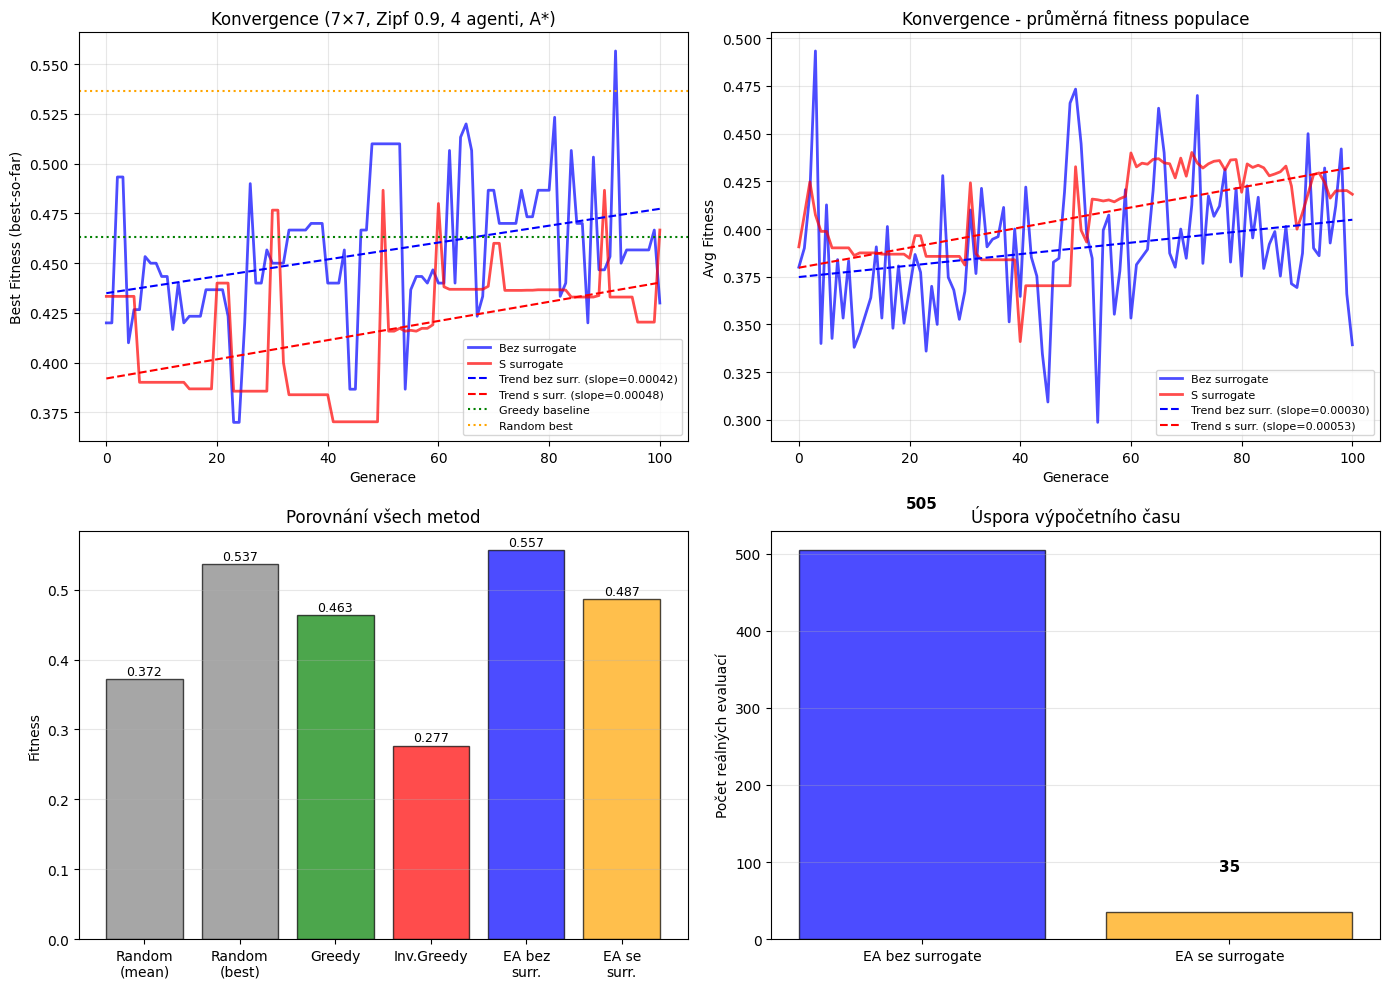

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Graf 1: Konvergence - best fitness
ax1 = axes[0, 0]
gens = np.arange(len(ea_no_surrogate['fitness_history']))
ax1.plot(gens, ea_no_surrogate['fitness_history'], 'b-',
         label='Bez surrogate', linewidth=2, alpha=0.7)
ax1.plot(gens, ea_with_surrogate['fitness_history'], 'r-',
         label='S surrogate', linewidth=2, alpha=0.7)

# Vertikální čáry pro generace s reálnou evaluací (surrogate model)
if 'real_eval_generations' in ea_with_surrogate:
    for i, gen in enumerate(ea_with_surrogate['real_eval_generations']):
        if i == 0:
            ax1.axvline(x=gen, color='red', linestyle=':', alpha=0.4, linewidth=1, label='Reálná evaluace')
        else:
            ax1.axvline(x=gen, color='red', linestyle=':', alpha=0.4, linewidth=1)

# Lineární trendy
z1 = np.polyfit(gens, ea_no_surrogate['fitness_history'], 1)
z2 = np.polyfit(gens, ea_with_surrogate['fitness_history'], 1)
ax1.plot(gens, np.poly1d(z1)(gens), 'b--', linewidth=1.5,
         label=f'Trend bez surr. (slope={z1[0]:.5f})')
ax1.plot(gens, np.poly1d(z2)(gens), 'r--', linewidth=1.5,
         label=f'Trend s surr. (slope={z2[0]:.5f})')

ax1.axhline(y=baseline_results['greedy']['fitness'], color='g',
            linestyle=':', label='Greedy baseline')
ax1.axhline(y=baseline_results['random']['best_fitness'], color='orange',
            linestyle=':', label='Random best')

ax1.set_xlabel('Generace')
ax1.set_ylabel('Best Fitness (best-so-far)')
ax1.set_title(f'Konvergence (7×7, Zipf {ZIPF_PARAM}, {N_AGENTS} agenti, A*)')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Graf 2: Konvergence - avg fitness
ax2 = axes[0, 1]
ax2.plot(gens, ea_no_surrogate['avg_fitness_history'], 'b-',
         label='Bez surrogate', linewidth=2, alpha=0.7)
ax2.plot(gens, ea_with_surrogate['avg_fitness_history'], 'r-',
         label='S surrogate', linewidth=2, alpha=0.7)

# Vertikální čáry pro generace s reálnou evaluací
if 'real_eval_generations' in ea_with_surrogate:
    for i, gen in enumerate(ea_with_surrogate['real_eval_generations']):
        if i == 0:
            ax2.axvline(x=gen, color='red', linestyle=':', alpha=0.4, linewidth=1, label='Reálná evaluace')
        else:
            ax2.axvline(x=gen, color='red', linestyle=':', alpha=0.4, linewidth=1)

# Lineární trendy pro avg fitness
z3 = np.polyfit(gens, ea_no_surrogate['avg_fitness_history'], 1)
z4 = np.polyfit(gens, ea_with_surrogate['avg_fitness_history'], 1)
ax2.plot(gens, np.poly1d(z3)(gens), 'b--', linewidth=1.5,
         label=f'Trend bez surr. (slope={z3[0]:.5f})')
ax2.plot(gens, np.poly1d(z4)(gens), 'r--', linewidth=1.5,
         label=f'Trend s surr. (slope={z4[0]:.5f})')

ax2.set_xlabel('Generace')
ax2.set_ylabel('Avg Fitness')
ax2.set_title('Konvergence - průměrná fitness populace')
ax2.legend(loc='lower right', fontsize=8)
ax2.grid(True, alpha=0.3)

# Graf 3: Porovnání metod
ax3 = axes[1, 0]
methods = ['Random\n(mean)', 'Random\n(best)', 'Greedy', 'Inv.Greedy',
           'EA bez\nsurr.', 'EA se\nsurr.']
values = [
    baseline_results['random']['mean_fitness'],
    baseline_results['random']['best_fitness'],
    baseline_results['greedy']['fitness'],
    baseline_results['inverse_greedy']['fitness'],
    ea_no_surrogate['best_fitness'],
    ea_with_surrogate['best_fitness']
]
colors = ['gray', 'gray', 'green', 'red', 'blue', 'orange']
bars = ax3.bar(methods, values, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Fitness')
ax3.set_title('Porovnání všech metod')
ax3.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# Graf 4: Počet evaluací
ax4 = axes[1, 1]
eval_methods = ['EA bez surrogate', 'EA se surrogate']
eval_counts = [ea_no_surrogate['real_evals'], ea_with_surrogate['real_evals']]
bars = ax4.bar(eval_methods, eval_counts, color=['blue', 'orange'],
               alpha=0.7, edgecolor='black')
ax4.set_ylabel('Počet reálných evaluací')
ax4.set_title('Úspora výpočetního času')
ax4.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, eval_counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('project_7x7_zipf09_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Hall of Fame - Top 5 nejlepších jedinců

In [101]:
# Hall of Fame - nejlepší jedinci
print("Hall of Fame (EA bez surrogate):")
print("-" * 40)
if 'hall_of_fame' in ea_no_surrogate:
    for rank, (individual, fitness) in enumerate(ea_no_surrogate['hall_of_fame'], 1):
        print(f"  #{rank}: fitness = {fitness:.4f}")
else:
    print("  (Spusťte notebook znovu pro zobrazení)")

print("\nHall of Fame (EA se surrogate):")
print("-" * 40)
if 'hall_of_fame' in ea_with_surrogate:
    for rank, (individual, fitness) in enumerate(ea_with_surrogate['hall_of_fame'], 1):
        print(f"  #{rank}: fitness = {fitness:.4f}")
else:
    print("  (Spusťte notebook znovu pro zobrazení)")

Hall of Fame (EA bez surrogate):
----------------------------------------
  (Spusťte notebook znovu pro zobrazení)

Hall of Fame (EA se surrogate):
----------------------------------------
  (Spusťte notebook znovu pro zobrazení)


## 11. Vizualizace nejlepšího rozložení

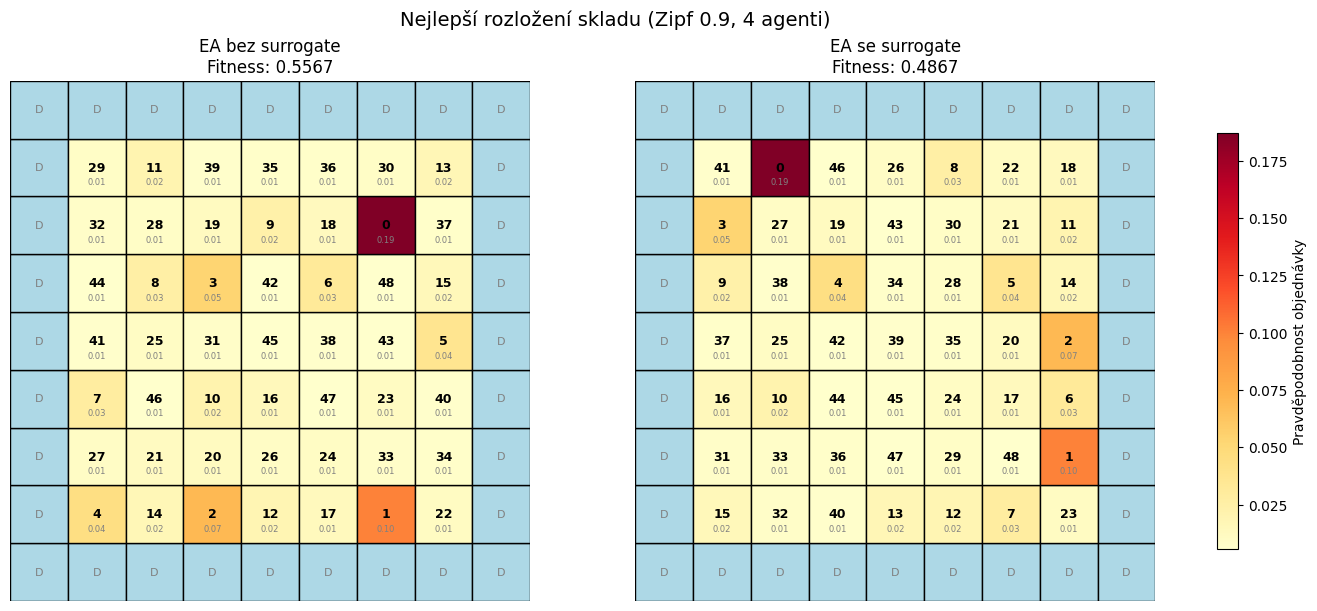


Analýza umístění top 5 nejpopulárnějších položek:
--------------------------------------------------

EA bez surrogate:
  #1 (goods 0, prob=0.187): pozice (6, 6), vzdálenost od okraje = 2
  #2 (goods 1, prob=0.100): pozice (6, 1), vzdálenost od okraje = 1
  #3 (goods 2, prob=0.070): pozice (3, 1), vzdálenost od okraje = 1
  #4 (goods 3, prob=0.054): pozice (3, 5), vzdálenost od okraje = 3
  #5 (goods 4, prob=0.044): pozice (1, 1), vzdálenost od okraje = 1

EA se surrogate:
  #1 (goods 0, prob=0.187): pozice (2, 7), vzdálenost od okraje = 1
  #2 (goods 1, prob=0.100): pozice (7, 2), vzdálenost od okraje = 1
  #3 (goods 2, prob=0.070): pozice (7, 4), vzdálenost od okraje = 1
  #4 (goods 3, prob=0.054): pozice (1, 6), vzdálenost od okraje = 1
  #5 (goods 4, prob=0.044): pozice (3, 5), vzdálenost od okraje = 3


In [102]:
# Vizualizace nejlepšího rozložení z obou metod
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
probs = og.get_probabilities()

for ax_idx, (title, results) in enumerate([
    ('EA bez surrogate', ea_no_surrogate),
    ('EA se surrogate', ea_with_surrogate)
]):
    ax = axes[ax_idx]
    best_layout = results['best_individual']
    wh.set_layout(best_layout)
    
    for y in range(GRID_SIZE):
        for x in range(GRID_SIZE):
            if x == 0 or x == GRID_SIZE-1 or y == 0 or y == GRID_SIZE-1:
                # Delivery point
                color = 'lightblue'
                ax.add_patch(plt.Rectangle((x, y), 1, 1, facecolor=color, edgecolor='black'))
                ax.text(x + 0.5, y + 0.5, 'D', ha='center', va='center', fontsize=8, color='gray')
            else:
                # Inner position - get goods ID and its probability
                inner_idx = (y - 1) * (GRID_SIZE - 2) + (x - 1)
                goods_id = best_layout[inner_idx]
                prob = probs[goods_id]
                
                # Color based on probability (normalized)
                norm_prob = (prob - probs.min()) / (probs.max() - probs.min())
                color = plt.cm.YlOrRd(norm_prob)
                
                ax.add_patch(plt.Rectangle((x, y), 1, 1, facecolor=color, edgecolor='black'))
                ax.text(x + 0.5, y + 0.5, f'{goods_id}', ha='center', va='center', fontsize=9, fontweight='bold')
                ax.text(x + 0.5, y + 0.25, f'{prob:.2f}', ha='center', va='center', fontsize=6, color='gray')
    
    ax.set_xlim(0, GRID_SIZE)
    ax.set_ylim(0, GRID_SIZE)
    ax.set_aspect('equal')
    ax.set_title(f'{title}\nFitness: {results["best_fitness"]:.4f}')
    
    # Kompletně skrýt osy
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# Colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, shrink=0.8, label='Pravděpodobnost objednávky')

fig.suptitle(f'Nejlepší rozložení skladu (Zipf {ZIPF_PARAM}, {N_AGENTS} agenti)', fontsize=14)
plt.savefig('project_7x7_zipf09_best_layout.png', dpi=150, bbox_inches='tight')
plt.show()

# Analýza - kde jsou nejpopulárnější položky?
print("\nAnalýza umístění top 5 nejpopulárnějších položek:")
print("-" * 50)
top_5_goods = np.argsort(probs)[-5:][::-1]

for method_name, results in [('EA bez surrogate', ea_no_surrogate), ('EA se surrogate', ea_with_surrogate)]:
    print(f"\n{method_name}:")
    layout = results['best_individual']
    wh.set_layout(layout)
    
    for rank, goods_id in enumerate(top_5_goods, 1):
        pos = wh.get_goods_position(goods_id)
        dist = wh.distance_to_nearest_edge(pos)
        print(f"  #{rank} (goods {goods_id}, prob={probs[goods_id]:.3f}): pozice {pos}, vzdálenost od okraje = {dist}")

## 12. Závěr

### Shrnutí experimentu

**Konfigurace:**
- Mapa: **7×7** (25 vnitřních pozic)
- Distribuce: **Zipf 0.9**
- Agenti: 2
- Planner: **A***

**Klíčové výsledky:**
- EA se surrogate modelem dosahuje srovnatelné (nebo lepší) fitness s výraznou úsporou výpočetního času
- Surrogate model (Ridge) má nízké R² (~0.036), přesto EA konverguje
- Speedup díky surrogate: ~5x méně reálných evaluací

**Pozorování:**
- Greedy baseline (populární zboží k okraji) paradoxně nevykazuje nejlepší výsledky
- EA nachází rozložení, která optimalizují nejen vzdálenost, ale i konfliktní situace mezi agenty